In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error

In [13]:
# read file
def read_dat(file_path):

    temp = []
    MSD = []
    
    with open(file_path, 'r') as f:
        lines = f.readlines()
        for line_num, line in enumerate(lines, start=1):
            if not line.startswith('#') and not line.startswith('@') and line.strip():
                parts = line.split()
                if len(parts) >= 2:  # Ensure there are at least two values
                    try:
                        temp.append(float(parts[0]))
                        MSD.append(float(parts[1]))
                    except ValueError as e:
                        print(f"Error converting line {line_num}: {line.strip()} -> {e}")
                else:
                    print(f"Skipping malformed line {line_num}: {line.strip()}")

    return np.array(temp), np.array(MSD)

temp, MSD = read_dat('temp_vs_500.dat')

In [17]:
# only need 800-100K for analysis of MSD
temp_800_onwards = temp[19:]  
MSD_800_onwards = MSD[19:]

low_temp_mask = temp_800_onwards <= 300  # low temp regime
high_temp_mask = temp_800_onwards >= 590  # high temp regime

low_temp_fit = np.polyfit(temp_800_onwards[low_temp_mask], MSD_800_onwards[low_temp_mask], 1)  
high_temp_fit = np.polyfit(temp_800_onwards[high_temp_mask], MSD_800_onwards[high_temp_mask], 1)  

x_low = np.linspace(min(temp_800_onwards[low_temp_mask]), max(temp_800_onwards[low_temp_mask]), 100) 
x_high = np.linspace(min(temp_800_onwards[high_temp_mask]), max(temp_800_onwards[high_temp_mask]), 100)

x_low_extrapolated = np.linspace(200, 800, 100)
x_high_extrapolated = np.linspace(450, 800, 100)

y_low = np.polyval(low_temp_fit, x_low)
y_high = np.polyval(high_temp_fit, x_high)

y_low_extrapolated = np.polyval(low_temp_fit, x_low_extrapolated)
y_high_extrapolated = np.polyval(high_temp_fit, x_high_extrapolated)

# intersection point for Tg
m_low, b_low = low_temp_fit  
m_high, b_high = high_temp_fit 
x_intersection = (b_high - b_low) / (m_low - m_high)
y_intersection = np.polyval(low_temp_fit, x_intersection)

# r^2 for low temp 
y_low_pred = np.polyval(low_temp_fit, temp_800_onwards[low_temp_mask])  # Predicted values
ss_res_low = np.sum((MSD_800_onwards[low_temp_mask] - y_low_pred) ** 2)  # Residual sum of squares
ss_tot_low = np.sum((MSD_800_onwards[low_temp_mask] - np.mean(MSD_800_onwards[low_temp_mask])) ** 2)  # Total sum of squares
r2_low = 1 - (ss_res_low / ss_tot_low)

# r^2 for high temp 
y_high_pred = np.polyval(high_temp_fit, temp_800_onwards[high_temp_mask])
ss_res_high = np.sum((MSD_800_onwards[high_temp_mask] - y_high_pred) ** 2)
ss_tot_high = np.sum((MSD_800_onwards[high_temp_mask] - np.mean(MSD_800_onwards[high_temp_mask])) ** 2)
r2_high = 1 - (ss_res_high / ss_tot_high)


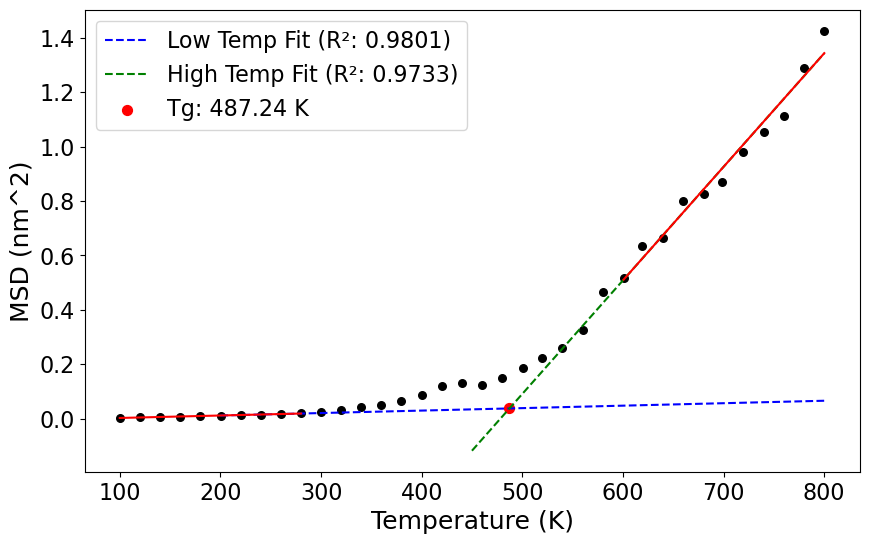

In [21]:
# graph
plt.figure(figsize=(10, 6))
plt.scatter(temp_800_onwards, MSD_800_onwards, marker='o', s=30, color='black')
plt.xlabel('Temperature (K)', fontsize=18)
plt.ylabel('MSD (nm^2)', fontsize=18)

plt.plot(x_low_extrapolated, y_low_extrapolated, color='blue', linestyle='--', markersize=1, label=f"Low Temp Fit (R²: {r2_low:.4f})")
plt.plot(x_high_extrapolated, y_high_extrapolated, color='green', linestyle='--', markersize=1, label=f"High Temp Fit (R²: {r2_high:.4f})")

#best fits
plt.plot(x_low, y_low, color='red', linestyle='-', markersize=2)
plt.plot(x_high, y_high, color='red', linestyle='-', markersize=2)

#tg
plt.scatter(x_intersection, y_intersection, color='red', marker='o', s=50, label=f"Tg: {x_intersection:.2f} K")

plt.legend(fontsize=16)
plt.xticks(fontsize=16)  
plt.yticks(fontsize=16)
plt.show()